# Bounding box detection - Racoon data (Object Localization)


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

Please note that each image in the dataset has one racoon.

### Import the necessary libraries

In [0]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import os 

from keras.applications.mobilenet import MobileNet, preprocess_input
from keras import Model
from keras.layers import Conv2D, Reshape, Dense
from keras.backend import epsilon

### Change directory

In [180]:
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/My Drive/Residency 9/lab_internal/images_racoon/images')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load the training data from train.csv file

In [0]:
train_df = pd.read_csv('../../train_labels.csv')

### Print the shape of the train dataset

In [182]:
print(train_df.shape)
train_df.head(5)

(173, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [0]:
IMAGE_SIZE = 128

#### Build a Batch Generator

The batch generator should do the following:

1. Take batch_size and dataframe (build from csv file above) as input
2. Build random row indexes equal to batch size from the dataframe
3. Based on random indexes created above, read the dataframe to do following:
   - Read image and resize the image to 128x128
   - Convert it to numpy array
   - Read bounding box co-ordinates from dataframe for this image
   - Resize co-ordinates as we have resized the image
   - 'yield' batch of images and batch of co-ordinates
   
Please note that there is no classification task here as all images do have racoon's in them.

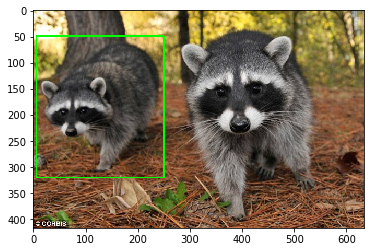

In [184]:
#Pickup a random image number
img_num = np.random.randint(0, train_df.shape[0])

#Read the image and draw a rectangle as per bounding box information
img = cv2.imread(train_df.loc[img_num,'filename'])
cv2.rectangle(img, 
             (train_df.loc[img_num, 'xmin'],train_df.loc[img_num, 'ymin']),
             (train_df.loc[img_num, 'xmax'],train_df.loc[img_num, 'ymax']), 
             (0,255,0), 2)
#Convert BGR format (used by opencv to RGB format used by matplotlib)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#Draw image using matplotlib
plt.imshow(img)
plt.show()

In [185]:
image_nums = np.random.randint(0,train_df.shape[0], size=32)
image_nums

array([  1, 164,  75, 145, 145, 105,  49,  26, 141, 129,   0,   9,   8,
       147, 123, 134, 164, 141, 159,  54, 167, 112, 121, 167, 108,  68,
        68, 117,  68, 107,  24,  20])

In [0]:
def batch_generator(df, batch_size=32):

    while True:

        #Create indexes
        image_nums = np.random.randint(0,df.shape[0], size=batch_size)

        #Create empty arrays
        #1. To hold image input
        batch_images = np.zeros(shape=(batch_size, IMAGE_SIZE, IMAGE_SIZE, 3))
        #Classification Labels 
        #batch_labels = np.zeros(shape=(batch_size, len(num_classes)))
        #Regression labels - 4 numbers per example image
        batch_bboxes = np.zeros(shape=(batch_size, 4))
        

        for i in range(batch_size):

            #Read image and resize
            img = tf.keras.preprocessing.image.load_img(df.loc[image_nums[i], 'filename'], 
                                                        target_size=(IMAGE_SIZE, IMAGE_SIZE))
            
            #Conver to numpy array
            img_array = tf.keras.preprocessing.image.img_to_array(img)

            #Update batch
            batch_images[i] = img_array


            #Read and resize bounding box co-ordinates
            img_width = df.loc[image_nums[i], 'width']
            img_height = df.loc[image_nums[i], 'height']
            
            xmin = df.loc[image_nums[i], 'xmin'] * IMAGE_SIZE/img_width
            xmax = df.loc[image_nums[i], 'xmax'] * IMAGE_SIZE/img_width

            ymin = df.loc[image_nums[i], 'ymin'] * IMAGE_SIZE/img_height
            ymax = df.loc[image_nums[i], 'ymax'] * IMAGE_SIZE/img_height

            #We will ask model to predict xmin, ymin, width and height of bounding box
            batch_bboxes[i] = [xmin, ymin, xmax-xmin, ymax-ymin]

        #Normalize batch images as per Pre-trained model to be used
        #batch_images = tf.keras.applications.resnet50.preprocess_input(batch_images)
        batch_images = preprocess_input(batch_images)
        
        #Make bounding boxes (x, y, w, h) as numbers between 0 and 1 - this seems to work better
        batch_bboxes = batch_bboxes/IMAGE_SIZE

        #Return batch - use yield function to make it a python generator
        yield batch_images, [batch_bboxes]

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [0]:
keras.backend.clear_session()
#Do not include top layer
model = MobileNet(include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), alpha = 1.0)

#to freeze layers, except the new top layer, which will be added below
for layer in model.layers:
  layer.trainable = False

#Add new top layer, which is a conv layer of the same saize as the previous layer
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
x = Reshape((4,))(x) # There are for predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=[x])

### Define a custom metric function IoU which calculates Intersection Over Union

In [0]:
def calculate_iou(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(calculate_iou, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [0]:
#Regression
model.compile(optimizer='adam', loss='mse', metrics=[IoU])


#Create train and test generator
batchsize = 32
train_generator = batch_generator(train_df, batch_size=batchsize) #batchsize can be changed
# test_generator = batch_generator(test_df, batch_size=batchsize)

In [0]:
model.fit_generator(train_generator, 
                          epochs=30,
                          steps_per_epoch= train_df.shape[0]//batchsize)

Epoch 1/30
5/5 [==============================] - 7s 1s/step - loss: 12.0988 - IoU: 0.0840
Epoch 2/30
5/5 [==============================] - 5s 995ms/step - loss: 6.6600 - IoU: 0.1022
Epoch 3/30
5/5 [==============================] - 5s 1s/step - loss: 5.1752 - IoU: 0.1164
Epoch 4/30
5/5 [==============================] - 5s 1s/step - loss: 4.5587 - IoU: 0.0520
Epoch 5/30
5/5 [==============================] - 5s 1s/step - loss: 4.2247 - IoU: 0.3060
Epoch 6/30
5/5 [==============================] - 5s 1s/step - loss: 3.8746 - IoU: 0.2187
Epoch 7/30
5/5 [==============================] - 5s 1s/step - loss: 2.9053 - IoU: 0.1256
Epoch 8/30
5/5 [==============================] - 5s 1s/step - loss: 2.9459 - IoU: 0.1635
Epoch 9/30
5/5 [==============================] - 5s 1s/step - loss: 2.7273 - IoU: 0.0826
Epoch 10/30
5/5 [==============================] - 5s 1s/step - loss: 2.5386 - IoU: 0.0877
Epoch 11/30
5/5 [==============================] - 5s 1s/step - loss: 1.9662 - IoU: 0.1003
Epoc

### Pick a test image from the given data

In [0]:

#Load image
img = tf.keras.preprocessing.image.load_img(train_df.loc[115, 'filename'])
w, h = img.size

#Read actual label and bounding box
xmin, ymin, xmax, ymax = train_df.loc[115, ['xmin', 'ymin', 'xmax', 'ymax']]



### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [0]:
img_size = 128
#Prepare input for model
#1. Resize image
img_resized = img.resize((img_size, img_size)) 
#2. Conver to array and make it a batch of 1
input_array = tf.keras.preprocessing.image.img_to_array(img_resized)
input_array = np.expand_dims(input_array, axis=0)
#3. Normalize image data
input_array = preprocess_input(input_array)



### Predict the coordinates of the bounding box for the given test image

In [176]:
#Prediction
pred = model.predict(input_array)
print(pred)



[[2.2706883 1.269223  4.414884  1.712283 ]]


### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

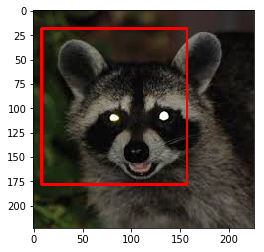

In [178]:
#Get classification and regression predictions
bbox_pred = pred[0]

#Draw bounding boxes - Actual (Red) and Predicted(Green)
img = cv2.imread(train_df.loc[115, 'filename'])
#Draw actual bounding box
img = cv2.rectangle(img, (xmin, ymin), 
                    (xmax, ymax), (0,0,255), 2)
#Draw predicted bounding box
img = cv2.rectangle(img, (int(bbox_pred[0]*w), int(bbox_pred[1]*h)), 
                    (int((bbox_pred[0]+bbox_pred[2])*w), int((bbox_pred[1]+bbox_pred[3])*h)), (0,255,0), 2)

#Display the picture
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [0]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

# Time Series Prediction using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temprature values to "Temprature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temprature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

#### Mount google drive

#### Change your present working directory

### Load your data file

#### Plot data

#### Descibe your dataframe

#### Check for null values

#### Drop null values

#### Get the representation of the distribution of data in the form of histogram

#### Check the maximum and minimum values

### Normalize the data

#### Check the maximum and minimum values of scaled data

#### Look into some of the scaled values

### Split data into Training and Testing

#### Print train and test size

## Create the sequential data
Map the temprature at a particular time t to the temprature at time t+n, where n is any number you define.

For example: to map tempratures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

#### Use function to get training and test set

#### Transform the prepared train and test input data into the expected structure using numpy.reshape()

## Define Model

### Define sequntial model, add LSTM layer and compile the model

### Summarize your model

### Train the model

## Make Predictions and Evaluate your model

## Plot the results